In [6]:
import numpy
import matplotlib.pyplot as plt
import pandas
import math

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

import tensorflow as tf
import keras

from keras.models import Sequential
from keras.layers import *
from keras.layers.wrappers import *
from keras.optimizers import RMSprop
from keras.callbacks import CSVLogger, EarlyStopping
# import keras.backend.tensorflow_backend as ktf

plt.style.use('ggplot')
%matplotlib inline
plt.rcParams['axes.facecolor'] = 'w'
plt.rcParams['axes.labelcolor'] = 'k'
plt.rcParams['axes.edgecolor'] = 'k'
plt.rcParams['ytick.color'] = 'k'
plt.rcParams['xtick.color'] = 'k'
plt.rcParams['grid.color'] = (.7, .7, .7, 0)
plt.rcParams['figure.figsize'] = (16, 10)

print('numpy ver.: ' + numpy.__version__)
print('pandas ver.: ' + pandas.__version__)
print('tensorflow ver.: ' + tf.__version__) 
print('keras ver.: ' + keras.__version__)
#データ読み込み
dataframe = pandas.read_csv('~/Evbus/evBus/1589-stop.csv', usecols=[0,1,2], engine='python', skipfooter=1)

config = tf.compat.v1.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.3
session = tf.compat.v1.Session(config=config)

numpy ver.: 1.19.1
pandas ver.: 1.1.3
tensorflow ver.: 2.2.0
keras ver.: 2.4.3


In [7]:
dataframe["lat"] = dataframe["lat"].map(lambda x: x-35)
dataframe["lon"] = dataframe["lon"].map(lambda x: x-139)
dataframe = dataframe.round(10)

In [8]:
print(dataframe.head)

<bound method NDFrame.head of             lat       lon  stop
0      0.459276  0.608063     0
1      0.459276  0.608063     0
2      0.459276  0.608063     0
3      0.459276  0.608063     0
4      0.459276  0.608063     0
...         ...       ...   ...
86394  0.459607  0.608588     0
86395  0.459607  0.608588     0
86396  0.459607  0.608588     0
86397  0.459607  0.608588     0
86398  0.459607  0.608588     0

[86399 rows x 3 columns]>


In [9]:
dataset = dataframe.values
dataset = dataset.astype('float64')
print(dataset[0])

[0.4592765 0.6080628 0.       ]


In [10]:
dataset_1 = dataset[25243:27804]
dataset_2 = dataset[31047:33493]
dataset_3 = dataset[38359:40785]
print(len(dataset_1))
print(len(dataset_2))
print(len(dataset_3))


# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset_1 = scaler.fit_transform(dataset_1)
dataset_2 = scaler.fit_transform(dataset_2)
dataset_3 = scaler.fit_transform(dataset_3)

dataset3 = dataset_3[0:1200]
test = dataset_3[1200:]
# # split into train and test sets
# train_size = int(len(dataset_real) * 0.67)
# test_size = len(dataset_real) - train_size
# train, test = dataset_real[0:train_size,:], dataset_real[train_size:len(dataset_real),:]
print(len(test))

2561
2446
2426
1226


In [11]:
print(dataset[0])

[0.4592765 0.6080628 0.       ]


In [12]:
print(dataset_1.shape)
print(dataset_1[0])

(2561, 3)
[0.99919749 0.01351687 1.        ]


In [15]:
# convert an array of values into a dataset matrix
# if you give look_back 3, a part of the array will be like this: Jan, Feb, Mar
def create_dataset(dataset, look_back=1, look_forward=1, t=1, step=1):
    dataX, dataY = [], []
    for i in range(0, (len(dataset)-look_back-look_forward-t-1), 1):
        xset, yset = [], []
        for j in range(dataset.shape[1]):
            a = dataset[i:(i+look_back):step, j]
            xset.append(a)
        for j in range(dataset.shape[1]):
            b = dataset[(i+look_back+t):(look_forward+look_back+t+i), j]
            yset.append(b)
        dataX.append(xset)
        dataY.append(yset)
    return numpy.array(dataX), numpy.array(dataY)

# use look_back --> predict look_forward after t seconds
look_back = 60     # number for real time(sec)
look_forward = 1   # number for real time(sec) 
t = 6              # time lag
step = 2           # extention variable

trainX_1, trainY_1 = create_dataset(dataset_1, look_back, look_forward, t, step)
trainX_2, trainY_2 = create_dataset(dataset_2, look_back, look_forward, t, step)
trainX_3, trainY_3 = create_dataset(dataset3, look_back, look_forward, t, step)

testX, testY = create_dataset(test, look_back, look_forward, t, step)
print(trainX_1.shape)
print(trainY_1.shape)
print(trainX_2.shape)
print(trainY_2.shape)
print(trainX_3.shape)
print(trainY_3.shape)

(2493, 3, 30)
(2493, 3, 1)
(2378, 3, 30)
(2378, 3, 1)
(1132, 3, 30)
(1132, 3, 1)


In [16]:
# concatenate test
trainX_12 = numpy.concatenate((trainX_1, trainX_2), axis=0)
trainY_12 = numpy.concatenate((trainY_1, trainY_2), axis=0)
print(trainX_12.shape)
print(trainY_12.shape)

(4871, 3, 30)
(4871, 3, 1)


In [17]:
trainX = numpy.concatenate((trainX_12,trainX_3), axis=0)
trainY = numpy.concatenate((trainY_12,trainY_3), axis=0)
print(trainX.shape)
print(trainY.shape)

(6003, 3, 30)
(6003, 3, 1)


In [11]:
print(testX.shape)
print(testY.shape)

(1158, 3, 60)
(1158, 3, 1)


In [18]:
trainX_trans = trainX.transpose((0, 2, 1))
trainY_trans = trainY.transpose((0, 2, 1))
testX_trans = testX.transpose((0, 2, 1))
testY_trans = testY.transpose((0, 2, 1))

print(trainX_trans.shape)
print(trainY_trans.shape)
print(testX_trans.shape)
print(testY_trans.shape)

(6003, 30, 3)
(6003, 1, 3)
(1158, 30, 3)
(1158, 1, 3)


In [21]:
trainX_re = trainX_trans.reshape((trainX_trans.shape[0], trainX_trans.shape[1], 1, trainX_trans.shape[2], 1))
trainY_re = trainY_trans.reshape((trainY_trans.shape[0], 1, 1, trainY_trans.shape[2], 1))
testX_re = testX_trans.reshape((testX_trans.shape[0], testX_trans.shape[1], 1, testX_trans.shape[2], 1))
testY_re = testY_trans.reshape((testY_trans.shape[0], 1, 1, testY_trans.shape[2], 1))

print(trainX_re.shape)
print(trainY_re.shape)
print(testX_re.shape)
print(testY_re.shape)

(6003, 30, 1, 3, 1)
(6003, 1, 1, 3, 1)
(1158, 30, 1, 3, 1)
(1158, 1, 1, 3, 1)


In [22]:
print(trainX_re[0,0,0])

[[0.99919749]
 [0.01351687]
 [1.        ]]


In [23]:
# create ConvLSTM
n_timesteps = trainX_re.shape[1]
output_timesteps = 1
model = Sequential()
model.add(BatchNormalization(name = 'batch_norm_0', input_shape = (n_timesteps, trainX_re.shape[2], trainX_re.shape[3], 1)))
model.add(ConvLSTM2D(name ='conv_lstm_1',
                     filters = 64, kernel_size = (10, 1),                       
                     padding = 'same', 
                     return_sequences = True,  input_shape = (n_timesteps, trainX_re.shape[2], trainX_re.shape[3], 1)))
    
model.add(Dropout(0.21, name = 'dropout_1'))
model.add(BatchNormalization(name = 'batch_norm_1'))

model.add(ConvLSTM2D(name ='conv_lstm_3',
                     filters = 64, kernel_size = (5, 1), 
                     padding='same',
                     return_sequences = False))
    
model.add(Dropout(0.20, name = 'dropout_3'))
model.add(BatchNormalization(name = 'batch_norm_3'))
    
model.add(Flatten())
model.add(RepeatVector(output_timesteps))
model.add(Reshape((output_timesteps, 1, 3, 64)))

model.add(ConvLSTM2D(name ='conv_lstm_4',
                     filters = 64, kernel_size = (10, 1), 
                     padding='same',
                     return_sequences = True))
    
model.add(Dropout(0.1, name = 'dropout_4'))
model.add(BatchNormalization(name = 'batch_norm_4'))

    
model.add(ConvLSTM2D(name ='conv_lstm_6',
                     filters = 64, kernel_size = (5, 1), 
                     padding='same',
                     return_sequences = True))
    
model.add(TimeDistributed(Dense(units=1, name = 'dense_1', activation = 'tanh')))
#model.add(Dense(units=1, name = 'dense_2'))

# optimizer = RMSprop() #lr=0.0001, rho=0.9, epsilon=1e-08, decay=0.9)
model.compile(loss = "mse", optimizer='adam', metrics=['mae', 'mape'])
model.summary()
# model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mae', 'mape'])
# model.fit(trainX_re, trainY_re, epochs=150, batch_size=64)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_norm_0 (BatchNormaliza (None, 30, 1, 3, 1)       4         
_________________________________________________________________
conv_lstm_1 (ConvLSTM2D)     (None, 30, 1, 3, 64)      166656    
_________________________________________________________________
dropout_1 (Dropout)          (None, 30, 1, 3, 64)      0         
_________________________________________________________________
batch_norm_1 (BatchNormaliza (None, 30, 1, 3, 64)      256       
_________________________________________________________________
conv_lstm_3 (ConvLSTM2D)     (None, 1, 3, 64)          164096    
_________________________________________________________________
dropout_3 (Dropout)          (None, 1, 3, 64)          0         
_________________________________________________________________
batch_norm_3 (BatchNormaliza (None, 1, 3, 64)          2

In [24]:
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mae', 'mape'])
model.fit(trainX_re, trainY_re, epochs=40, validation_split=0.1, shuffle=False, batch_size=64)

Epoch 1/40
85/85 [==============================] - 55s 647ms/step - loss: 0.0724 - mae: 0.1729 - mape: 45490252.0000 - val_loss: 0.1135 - val_mae: 0.2470 - val_mape: 37668828.0000
Epoch 2/40
85/85 [==============================] - 45s 529ms/step - loss: 0.0471 - mae: 0.1379 - mape: 36321972.0000 - val_loss: 0.0927 - val_mae: 0.2395 - val_mape: 57215940.0000
Epoch 3/40
85/85 [==============================] - 45s 531ms/step - loss: 0.0452 - mae: 0.1326 - mape: 32849888.0000 - val_loss: 0.0765 - val_mae: 0.2309 - val_mape: 67328824.0000
Epoch 4/40
85/85 [==============================] - 45s 525ms/step - loss: 0.0444 - mae: 0.1343 - mape: 35255836.0000 - val_loss: 0.0544 - val_mae: 0.1933 - val_mape: 61885132.0000
Epoch 5/40
85/85 [==============================] - 45s 528ms/step - loss: 0.0438 - mae: 0.1350 - mape: 34778672.0000 - val_loss: 0.0339 - val_mae: 0.1420 - val_mape: 60538620.0000
Epoch 6/40
85/85 [==============================] - 45s 530ms/step - loss: 0.0416 - mae: 0.1313

In [28]:
# model.save('C:/Users/Hailin/OneDrive/ドキュメント/熊大関連/尼崎研/EV-Bus/evBus-main/evBus-main/Conv-LSTM-withStopInfo-ver15-Y-U.h5')
# model.save('C:/Users/kinkr/OneDrive/ドキュメント/熊大関連/尼崎研/EV-Bus/evBus-main/evBus-main/ConvLSTM_train70_version04.h5')
model.save('/user/arch/jin/Evbus/evBus/Conv-LSTM-withStopInfo-ver16-Y-U.h5')

In [19]:
model = tf.keras.models.load_model('C:/Users/hailin/OneDrive/ドキュメント/熊大関連/尼崎研/EV-Bus/evBus-main/evBus-main/Conv-LSTM-withStopInfo-ver15-Y-U.h5')

In [29]:
print(testX_trans.shape)
print(testY_trans.shape)
print(testX_re[0,0])

(1158, 30, 3)
(1158, 1, 3)
[[[0.5735277 ]
  [0.29520932]
  [0.        ]]]


In [30]:
testPredict = model.predict(testX_re)

In [31]:
print(testPredict.shape)
print(testPredict[0,0,0])

(1158, 1, 1, 3, 1)
[[ 0.60632634]
 [ 0.23556697]
 [-0.08791509]]


In [32]:
testPredict_reshaped = testPredict.reshape((-1,3))
testY_reshaped = testY_re.reshape((-1,3))
print(testPredict_reshaped.shape)
print(testY_reshaped.shape)
print(type(testPredict_reshaped))

(1158, 3)
(1158, 3)
<class 'numpy.ndarray'>


In [24]:
# testPredict_reshaped_plus= numpy.insert(testPredict_reshaped, 2, values=1, axis=1)
# testY_reshaped_plus = numpy.insert(testY_reshaped, 2, values=1, axis=1)
# print(testY_reshaped.shape)
# print(testPredict_reshaped.shape)

In [33]:
testPredict_reshaped_inv = scaler.inverse_transform(testPredict_reshaped)
testY_reshaped_inv = scaler.inverse_transform(testY_reshaped)

In [34]:
print(testPredict_reshaped_inv[0])
print(testY_reshaped_inv[0])

[ 0.44987684  0.638468   -0.08791509]
[0.44743706 0.6460159  0.        ]


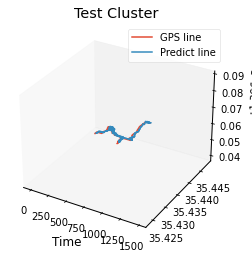

In [21]:
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D

mpl.rcParams['legend.fontsize'] = 10
 
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot(range(len(testY_reshaped_inv)), testY_reshaped_inv[:,0], testY_reshaped_inv[:,1], label='GPS line')
ax.plot(range(len(testPredict_reshaped_inv)), testPredict_reshaped_inv[:,0], testPredict_reshaped_inv[:,1], label='Predict line')
ax.set_xlabel('Time')
ax.legend()
plt.title('Test Cluster')
# plt.savefig("C:/Users/Hailin/OneDrive/ドキュメント/熊大関連/尼崎研/EV-Bus/evBus-main/evBus-main/Conv-LSTM/ConvLSTM-verson04.svg", format="svg")
 
plt.show()

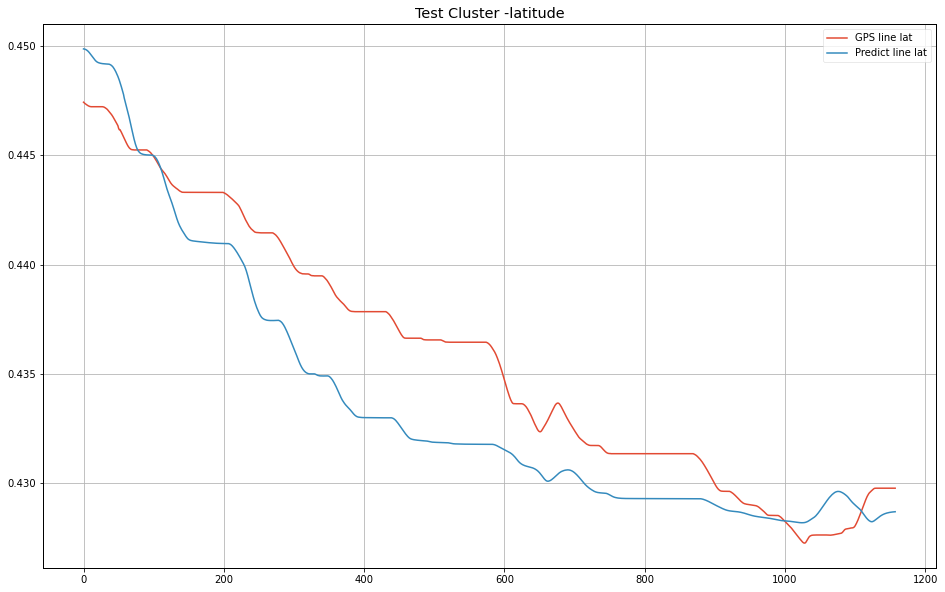

In [35]:
plt.plot(range(len(testY_reshaped_inv)), testY_reshaped_inv[:,0], label='GPS line lat')
plt.plot(range(len(testPredict_reshaped_inv)), testPredict_reshaped_inv[:,0], label='Predict line lat')
plt.title('Test Cluster -latitude')

plt.legend() 

# plt.savefig("C:/Users/kinkr/OneDrive/ドキュメント/熊大関連/尼崎研/EV-Bus/evBus-main/evBus-main/Conv-LSTM/Conv-LSTM-withStopInfo-ver02-Y-U-lat.svg", format="svg")
plt.show()

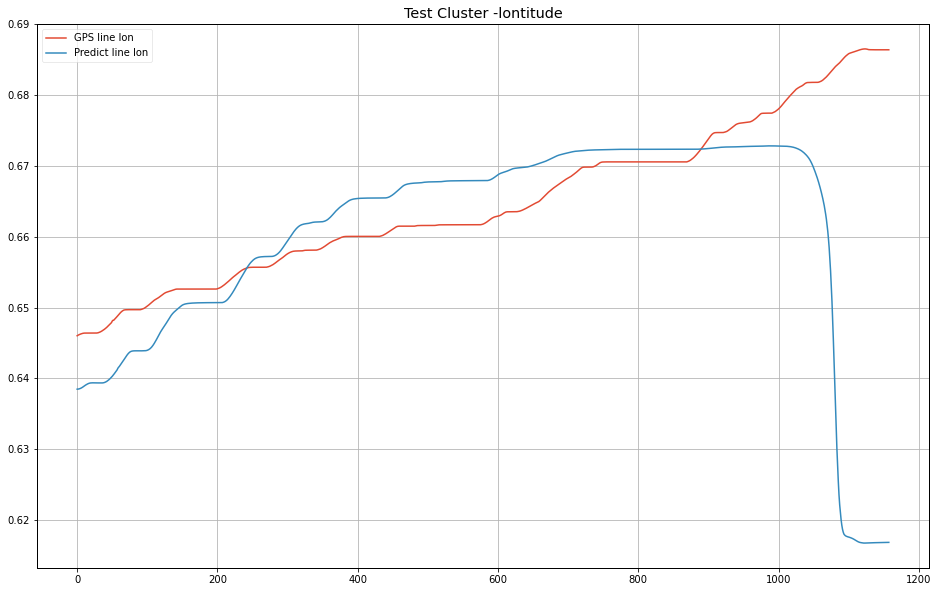

In [36]:
plt.plot(range(len(testY_reshaped_inv)), testY_reshaped_inv[:,1], label='GPS line lon')
plt.plot(range(len(testPredict_reshaped_inv)), testPredict_reshaped_inv[:,1], label='Predict line lon')
plt.title('Test Cluster -lontitude')

plt.legend() 

# plt.savefig("C:/Users/kinkr/OneDrive/ドキュメント/熊大関連/尼崎研/EV-Bus/evBus-main/evBus-main/Conv-LSTM/Conv-LSTM-withStopInfo-ver02-Y-U-lon.svg", format="svg")
plt.show()

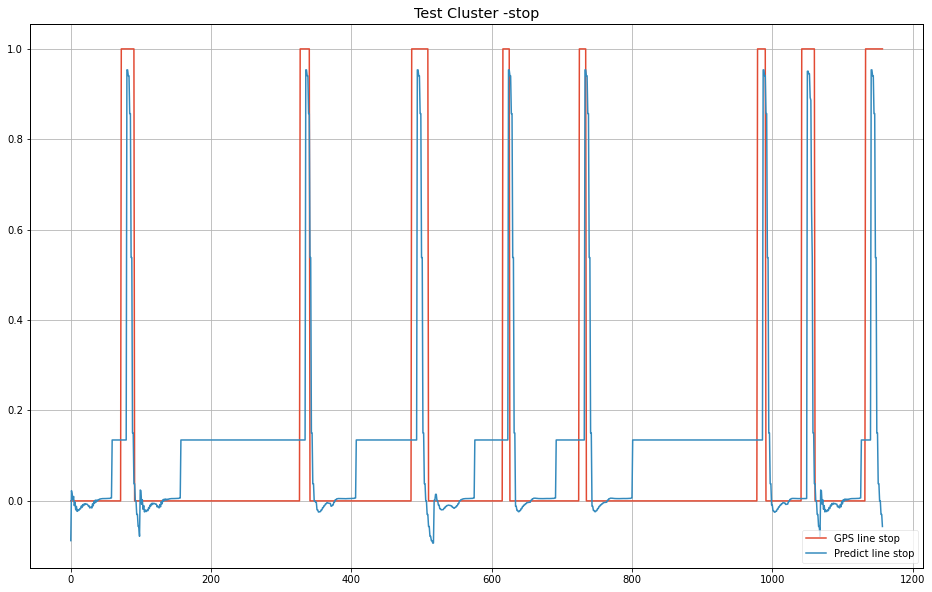

In [37]:
plt.plot(range(len(testY_reshaped_inv)), testY_reshaped_inv[:,2], label='GPS line stop')
plt.plot(range(len(testPredict_reshaped_inv)), testPredict_reshaped_inv[:,2], label='Predict line stop')
plt.title('Test Cluster -stop')

plt.legend() 

# plt.savefig("C:/Users/Hailin/OneDrive/ドキュメント/熊大関連/尼崎研/EV-Bus/evBus-main/evBus-main/Conv-LSTM/ConvLSTM-verson04-lati.svg", format="svg")
plt.show()

In [38]:
st = 320
ed = 340
testX_re2 = testX_re[st:ed]
testY_re2 = testY_re[st:ed]
print(testX_re2.shape)

(20, 30, 1, 3, 1)


In [39]:
testPredict2 = model.predict(testX_re2)

In [40]:
print(testPredict2.shape)

(20, 1, 1, 3, 1)


In [41]:
testPredict_reshaped2 = testPredict2.reshape((-1,3))
testY_reshaped2 = testY_re2.reshape((-1,3))
testPredict_reshaped_inv2 = scaler.inverse_transform(testPredict_reshaped2)
testY_reshaped_inv2 = scaler.inverse_transform(testY_reshaped2)

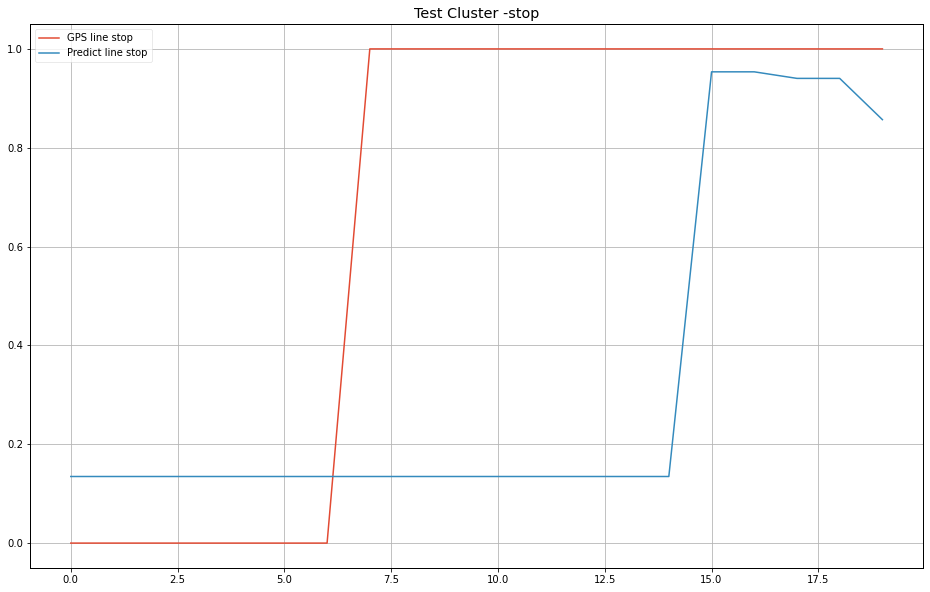

In [42]:
plt.plot(range(len(testY_reshaped_inv2)), testY_reshaped_inv2[:,2], label='GPS line stop')
plt.plot(range(len(testPredict_reshaped_inv2)), testPredict_reshaped_inv2[:,2], label='Predict line stop')
plt.title('Test Cluster -stop')

plt.legend() 

# plt.savefig("C:/Users/Hailin/OneDrive/ドキュメント/熊大関連/尼崎研/EV-Bus/evBus-main/evBus-main/Conv-LSTM/ConvLSTM-verson04-lati.svg", format="svg")
plt.show()

In [24]:
import numpy as np
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred) 
    return np.mean(np.abs((y_true - y_pred)/y_true))

error_lat = mean_absolute_percentage_error(testY_reshaped_inv[:,0], testPredict_reshaped_inv[:,0])
error_lon = mean_absolute_percentage_error(testY_reshaped_inv[:,1], testPredict_reshaped_inv[:,1])
print(error_lat)
print(error_lon)

1.8841756e-05
8.813733e-06


In [25]:
print(test.shape)
print(test[0])

(1597, 3)
[0.6479492  0.13110352 0.        ]


In [30]:
import numpy as np
start = 400
sheed = np.reshape(test[start:start+60], (1, 60, 1, 3, 1))
# prediction = sheed

# for i in range(70):
prediction = model.predict(sheed)
# sheed = np.concatenate((sheed[:, 15:, :, :, :], res), axis=1)
# prediction = np.concatenate((prediction, res), axis=1)

In [31]:
print(prediction.shape)

(1, 1, 1, 3, 1)


In [33]:
prediction = numpy.squeeze(prediction,axis=0)
print(prediction.shape)
print(prediction[0])

(1, 1, 3, 1)
[[[0.55700225]
  [0.38348374]
  [0.        ]]]


In [34]:
prediction = numpy.squeeze(prediction,axis=0)
print(prediction.shape)
print(prediction[0])

(1, 3, 1)
[[0.55700225]
 [0.38348374]
 [0.        ]]


In [35]:
prediction = numpy.squeeze(prediction,axis=2)
print(prediction.shape)
print(prediction[0])

(1, 3)
[0.55700225 0.38348374 0.        ]


In [36]:
test_re2 = scaler.inverse_transform(test)
prediction_re2 = scaler.inverse_transform(prediction)
print(test[start])
print(prediction[0])

[0.5508423  0.34106445 0.        ]
[0.55700225 0.38348374 0.        ]


In [37]:
print(test_re2[start+90])
print(prediction_re2[0])
print(len(prediction_re2))

[ 35.44612 139.6483    0.     ]
[ 35.448036 139.64777    0.      ]
1


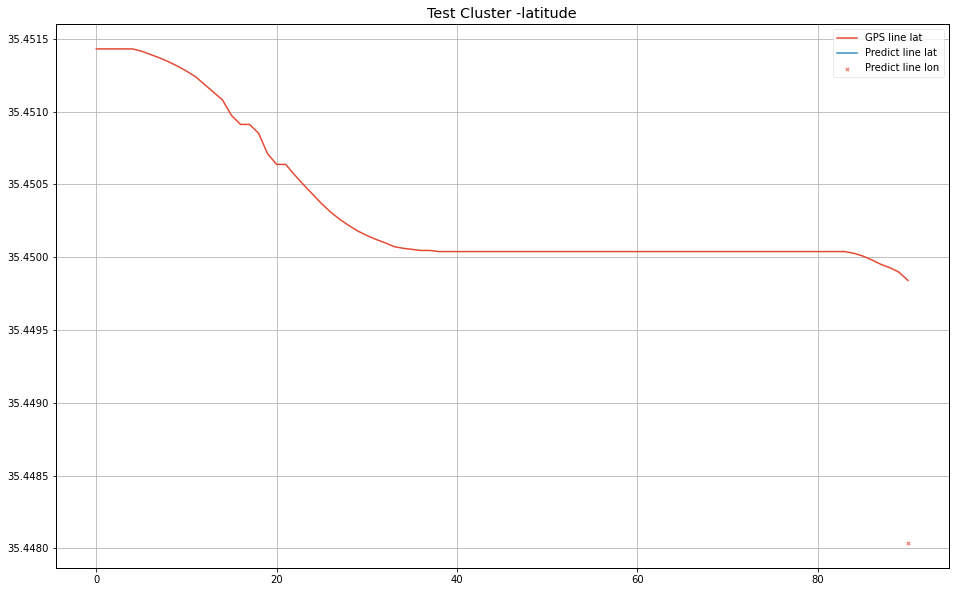

In [43]:
plt.plot(range(91), test_re2[0:91,0], label='GPS line lat')
plt.plot(90, prediction_re2[:,0], label='Predict line lat')
plt.scatter(90, prediction_re2[:,0], label='Predict line lon', alpha=0.6, s=10, marker="x")

plt.title('Test Cluster -latitude')

plt.legend() 

# plt.savefig("C:/Users/Hailin/OneDrive/ドキュメント/熊大関連/尼崎研/EV-Bus/evBus-main/evBus-main/Conv-LSTM/ConvLSTM-verson01-lati.svg", format="svg")
plt.show()

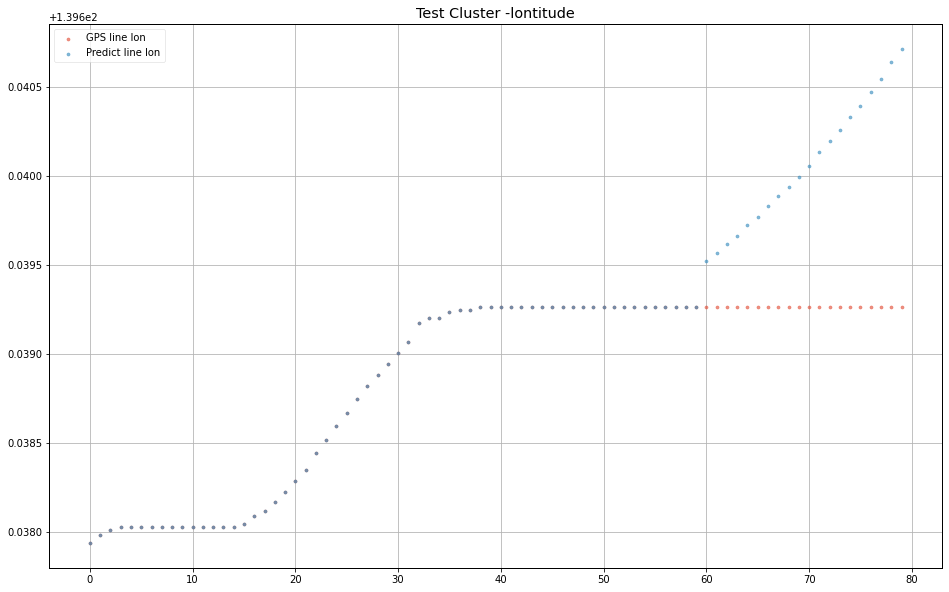

In [58]:
plt.scatter(range(len(prediction_re2)), test_re2[start:start+len(prediction_re2),1], label='GPS line lon', alpha=0.6, s=10)
plt.scatter(range(len(prediction_re2)), prediction_re2[:,1], label='Predict line lon', alpha=0.6, s=10)
plt.title('Test Cluster -lontitude')

plt.legend() 

# plt.savefig("C:/Users/Hailin/OneDrive/ドキュメント/熊大関連/尼崎研/EV-Bus/evBus-main/evBus-main/Conv-LSTM/ConvLSTM-verson01-lati.svg", format="svg")
plt.show()